# Phase Space Expansion

The goal of this code is to generate new phase space data based on existing data.

First, let's load our data into a PhaseSpace object:

In [1]:
from pathlib import Path
from ParticlePhaseSpace import DataLoaders
from ParticlePhaseSpace import PhaseSpace
from scipy.stats import gaussian_kde
import numpy as np
from matplotlib import pyplot as plt

data_loc_12MeV = Path(r'C:\Users\Brendan\Dropbox (Sydney Uni)\Projects\Tibaray_planning\tibaray_phase\ExternalShare_Linacs_PhaseSpace\3D_12MeV_Cav45ExitScreen\Cavity45.SourceCav1Beam.exitingCav45.3D.dat')
# Instantiate Electron Phase Space object:
data = DataLoaders.Load_TibarayData(data_loc_12MeV, particle_type='electrons')
PS = PhaseSpace(data)
# filter by time (explained in other example)
PS = PS.filter_by_time(t_start=2.66, t_finish=2.76)

Original data contains  37492 particles
Filtered data contains  11968 particles


And take a look at the data:

In [2]:
PS.ps_data.head()

,x [mm],y [mm],z [mm],time [ps],weight,particle id,particle type [pdg_code],px [MeV/c],py [MeV/c],pz [MeV/c]
13036,-0.149543,0.033104,700.356989,2.665822,33487.6116,13037.0,11,-0.010264,0.002272,0.458194
13037,-0.140851,0.060166,700.356989,2.665822,33487.6116,13038.0,11,-0.009668,0.004130,0.458194
13038,-0.054539,0.143124,700.356989,2.665822,33487.6116,13039.0,11,-0.003743,0.009824,0.458194
13039,-0.100198,-0.115842,700.356989,2.665822,33487.6116,13040.0,11,-0.006877,-0.007951,0.458194
13040,0.420379,0.206117,700.356989,2.687586,25115.7087,13041.0,11,0.002698,0.001323,12.611233


## Fit a gaussian KDE to 7-D space

We have seven dimensions we care about (i'm ignoring time):

`x, y, z, px, py, pz, weight`

We cannot assume that any of these quantities are independant: we have to assume correlations exist between all 7.

For this step, I am going to fit a [gaussian kernel density estimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html) to the existing points.

> **is this a good thing to do??** Probably not, but let's see what the data looks like...

In [3]:
n_new_particles = len(PS)  # we will double the phase space
xyz_pxpypz_w = np.vstack([PS.ps_data[PS._columns['x']],
                PS.ps_data[PS._columns['y']],
                PS.ps_data[PS._columns['z']],
                PS.ps_data[PS._columns['px']],
                PS.ps_data[PS._columns['py']],
                PS.ps_data[PS._columns['pz']],
                PS.ps_data[PS._columns['weight']] ])
k = gaussian_kde(xyz_pxpypz_w)
new_points = k.resample(n_new_particles)

In [4]:
new_points.shape

(7, 11968)

## Load this data into a new PhaseSpace object

Now we have generated some new data points, we can load this data into a new PhaseSpace object and compare it to the original.

In [5]:
import pandas as pd

new_data = pd.DataFrame(
    {'x [mm]': new_points[0,:],
     'y [mm]': new_points[1,:],
     'z [mm]': new_points[2,:],
     'px [MeV/c]': new_points[3,:],
     'py [MeV/c]': new_points[4,:],
     'pz [MeV/c]': new_points[5,:],
     'particle type [pdg_code]': 11,
     'weight': new_points[6,:],
     'particle id': np.arange(n_new_particles),
     'time [ps]': PS.ps_data[PS._columns['time']].mean()})

from ParticlePhaseSpace import DataLoaders

new_data = DataLoaders.Load_PandasData(new_data)

new_PS = PhaseSpace(new_data)

## Compare the old data to the new data

Now that we have both an old and a new set of data, I'm going to run a series of plots to compare how well this has worked.

## Energy

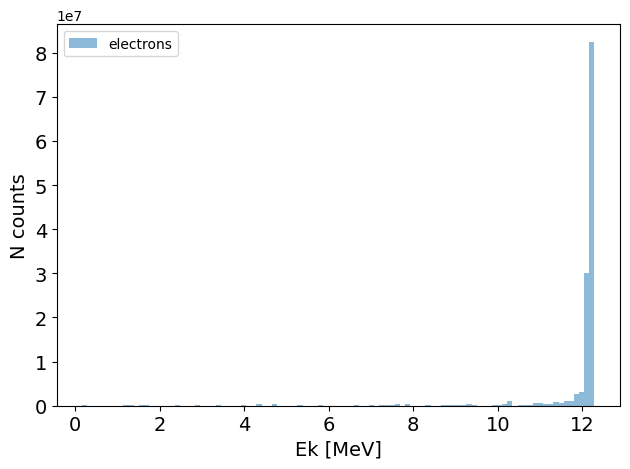

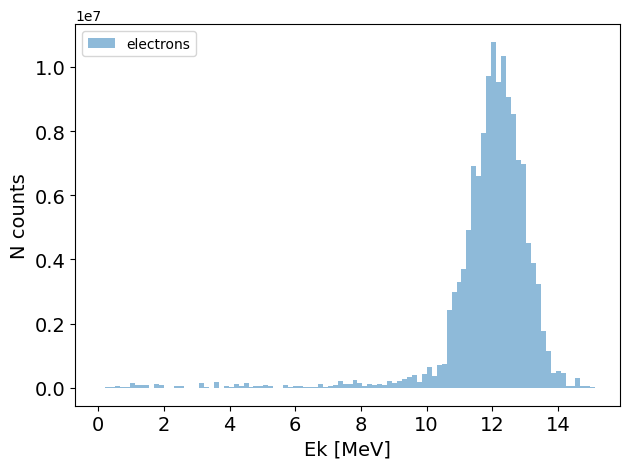

In [6]:
PS.plot_energy_hist_1D()
new_PS.plot_energy_hist_1D()

## Particle positions

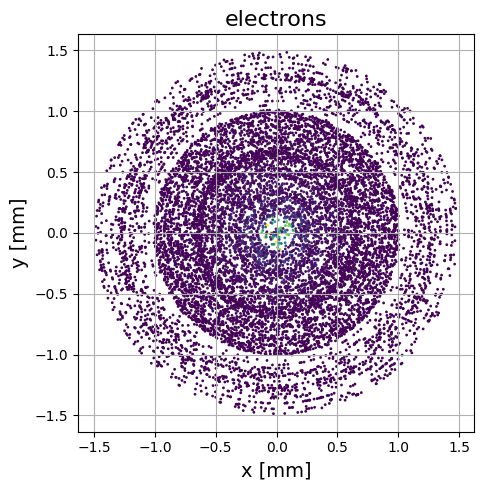

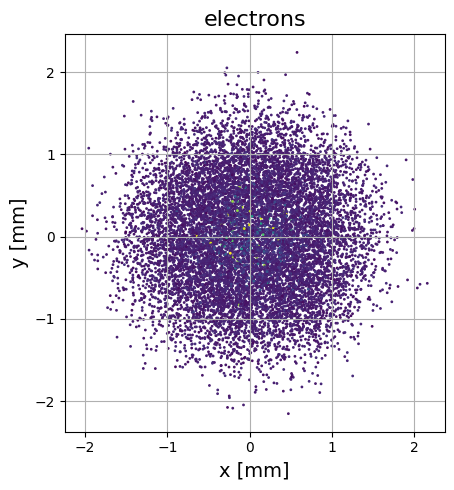

In [7]:
PS.plot_particle_positions_scatter_2D()
new_PS.plot_particle_positions_scatter_2D()

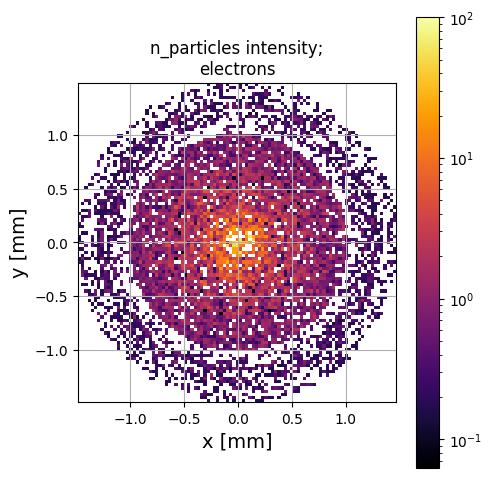

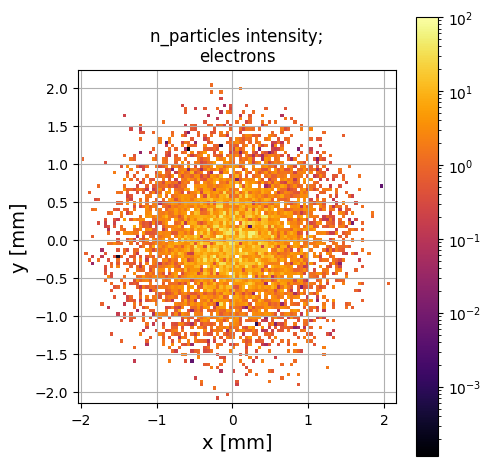

In [8]:
PS.plot_particle_positions_hist_2D(log_scale=True)
new_PS.plot_particle_positions_hist_2D(log_scale=True)

## Particle Weights

Text(0, 0.5, 'n_counts')

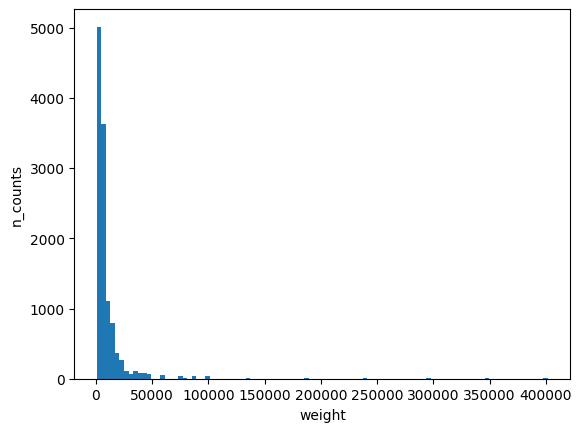

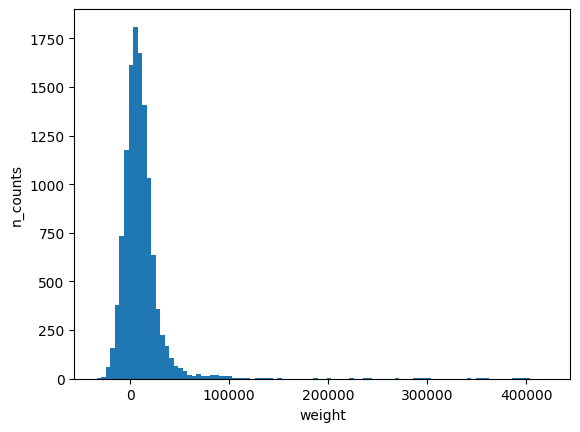

In [9]:
plt.figure()
plt.hist(PS.ps_data['weight'], 100)
plt.xlabel('weight')
plt.ylabel('n_counts')

plt.figure()
plt.hist(new_PS.ps_data['weight'], 100)
plt.xlabel('weight')
plt.ylabel('n_counts')

## Trace Space

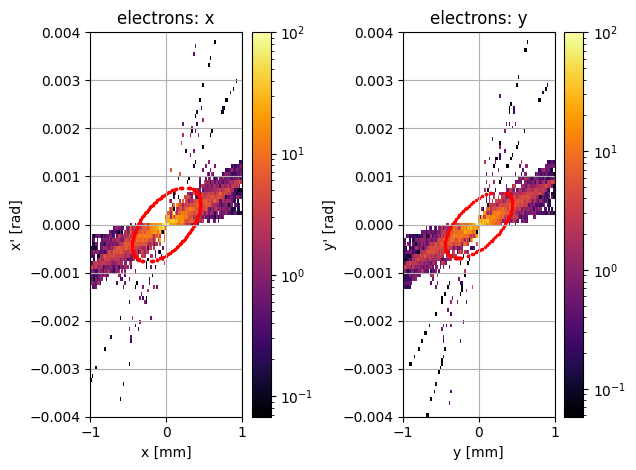

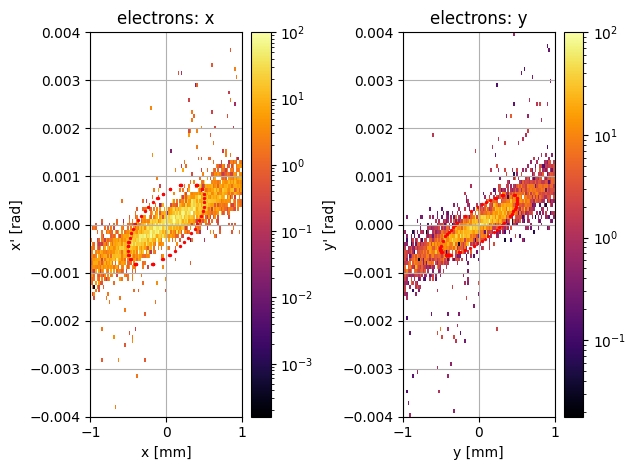

In [10]:
PS.plot_transverse_trace_space_hist_2D(plot_twiss_ellipse=True, xlim=[-1, 1], ylim=[-.004, .004])
new_PS.plot_transverse_trace_space_hist_2D(plot_twiss_ellipse=True, xlim=[-1, 1], ylim=[-.004, .004])

## Conclusions

- This actually has worked pretty well, but well enough? I really don't think so. 
- The sensible way to generate a robust, statistically valid phase space with sufficient particles is to simulate it.
- It is possible that some techniques would perform better than  a gaussian KDE. In particular, this is the type of problem to which a machine learning approach would actually be well suited. However, i don't really have time or energy to do that.